# Logistic Regression Model

## Data Import And Cleaning

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import scripts.logistic_regression_functions as lrf
import scripts.helper_functions as hf
from functools import partial

In [40]:
train_files = ['../../data/cleaned/utah_2017_vineyard.csv', 
               '../../data/cleaned/utah_2017_marina.csv']

test_files = ['../../data/cleaned/utah_2018_marina.csv',
               '../../data/cleaned/utah_2018_bird.csv']

drop_columns = ['Chlorophyll ug/L', 'Chlorophyll RFU', 'Wiper Pos V',
                'Cable Pwr V', 'Battery V', 'Chlorophyll (ug/L)', 'FDOM RFU']

x_columns = ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
            'ODOSat%', 'ODO (mg/L)']

target_column = 'BGA-Phycocyanin RFU'

# TODO Create average off of minor bloom
RFU_THRESHOLD = 1.2
train_index = 0
test_index = 0
#the operation to be used for math operations during training.
math_operation = partial(np.square)

In [41]:
# Load the data
train_dfs = lrf.import_df_data(train_files, drop_columns)
test_dfs = lrf.import_df_data(test_files, drop_columns)

train_dfs[train_index].head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4


In [42]:
test_dfs[test_index].head()

,Time America/Boise UTC-06:00,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,4/11/2018 10:30,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6
1,4/11/2018 10:45,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6
2,4/11/2018 11:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7
3,4/11/2018 11:15,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7
4,4/11/2018 11:30,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7


In [43]:
train_dfs[train_index].describe()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
count,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000
mean,18.488235,1933.564575,-116.806951,8.633415,58.129348,87.056980,8.179008,0.979511
std,6.134464,151.800551,8.973830,0.147231,54.622278,13.793755,1.278416,0.731423
min,5.630000,3.000000,-153.700000,7.930000,0.660000,62.800000,5.170000,0.000000
25%,12.700000,1848.000000,-120.800000,8.530000,29.850000,80.000000,7.260000,0.500000
50%,20.320000,1939.000000,-115.700000,8.650000,42.140000,83.200000,8.080000,0.900000
75%,23.630000,2070.000000,-112.100000,8.700000,65.795000,88.900000,9.250000,1.200000
max,28.570000,2164.000000,-76.500000,9.230000,636.700000,209.700000,16.170000,16.100000


In [44]:
test_dfs[test_index].describe()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
count,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000
mean,19.131184,1990.294607,-196.624329,8.922357,63.929067,90.057202,8.309566,1.459773
std,5.045367,230.743946,27.769024,0.357733,70.885989,17.627283,1.486747,1.311960
min,0.000000,0.000000,-284.000000,0.000000,-0.880000,0.000000,0.000000,-0.400000
25%,15.480000,1869.000000,-216.950000,8.730000,33.750000,79.100000,7.280000,0.600000
50%,20.190000,1958.000000,-192.000000,8.920000,48.380000,85.300000,8.010000,1.000000
75%,23.070000,2149.000000,-179.500000,9.100000,68.275000,95.300000,9.240000,1.700000
max,28.600000,2417.000000,0.000000,10.100000,1248.920000,245.500000,19.590000,21.100000


## Use Datetime Index

In [45]:
print(test_dfs[test_index].dtypes)
print(train_dfs[train_index].dtypes)

Time America/Boise UTC-06:00     object
Temp C                          float64
Sp Cond (uS/cm)                   int64
pH (mV)                         float64
pH                              float64
Turbidity (NTU)                 float64
ODOSat%                         float64
ODO (mg/L)                      float64
BGA-Phycocyanin RFU             float64
dtype: object
Date (mm.dd.yyyy)       object
Time 24hr               object
Temp C                 float64
Sp Cond (uS/cm)          int64
pH (mV)                float64
pH                     float64
Turbidity (NTU)        float64
ODOSat%                float64
ODO (mg/L)             float64
BGA-Phycocyanin RFU    float64
dtype: object


In [46]:
# We will need to engineer a datetime column for our 2017 data

# Create a single datetime column from the strings provided in our csv's
for i in range(0, len(train_dfs)):
    timestamp = train_dfs[i]['Date (mm.dd.yyyy)'] + ' '+ train_dfs[i]['Time 24hr']
    timestamp = pd.to_datetime(timestamp)
    train_dfs[i]['timestamp'] = timestamp
    train_dfs[i]['datetime'] = timestamp
    #since we dont want to give day of the month the same weight, we are adding day of the year as a category
    train_dfs[i] = train_dfs[i].set_index('timestamp')
    train_dfs[i] = train_dfs[i].drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
train_dfs[train_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00


In [47]:
# Now to datetime index our 2018 data
for i in range(0, len(test_dfs)):
    timestamp = pd.to_datetime(test_dfs[i]['Time America/Boise UTC-06:00'])
    test_dfs[i]['timestamp'] = timestamp
    test_dfs[i]['datetime'] = timestamp
    #since we dont want to give day of the month the same weight, we are adding day of the year as a category
    test_dfs[i] = test_dfs[i].set_index('timestamp')
    test_dfs[i] = test_dfs[i].drop(columns=['Time America/Boise UTC-06:00'])
test_dfs[test_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00


## Fill missing values


In [48]:
# Fill all missing values with the mean
for df in test_dfs + train_dfs:
    for column in df.columns:
        number_null = np.sum(df[column].isnull())
        column_length = len(df[column])
        print('{} percent null: {:.1f}%'.format(
            column, (number_null / column_length) * 100))
        if number_null > 0:
            print("Filling {} with mean: {}\n".format(column, df[column].mean()))
            df[column] = df[column].fillna(df[column].mean()) 

Temp C percent null: 0.0%
Sp Cond (uS/cm) percent null: 0.0%
pH (mV) percent null: 0.0%
pH percent null: 0.0%
Turbidity (NTU) percent null: 0.0%
ODOSat% percent null: 0.0%
ODO (mg/L) percent null: 0.0%
BGA-Phycocyanin RFU percent null: 0.0%
datetime percent null: 0.0%
Temp C percent null: 0.0%
Sp Cond (uS/cm) percent null: 0.0%
pH (mV) percent null: 0.0%
pH percent null: 0.0%
Turbidity (NTU) percent null: 0.0%
ODOSat% percent null: 0.0%
ODO (mg/L) percent null: 0.0%
BGA-Phycocyanin RFU percent null: 0.0%
datetime percent null: 0.0%
Temp C percent null: 0.0%
Sp Cond (uS/cm) percent null: 0.0%
pH (mV) percent null: 0.0%
pH percent null: 0.0%
Turbidity (NTU) percent null: 0.0%
ODOSat% percent null: 0.0%
ODO (mg/L) percent null: 0.0%
BGA-Phycocyanin RFU percent null: 0.0%
datetime percent null: 0.0%
Temp C percent null: 0.0%
Sp Cond (uS/cm) percent null: 0.0%
pH (mV) percent null: 0.0%
pH percent null: 0.0%
Turbidity (NTU) percent null: 3.2%
Filling Turbidity (NTU) with mean: 64.9625066543

In [49]:
# DELETE THIS CELL
df = train_dfs[train_index].copy()
start = pd.to_datetime("05/29/2017")
end = pd.to_datetime("06/16/2017")
df[start:end][target_column].mean()

0.3452284557547656

In [50]:
# DELETE THIS CELL
df = train_dfs[train_index].copy()
start = pd.to_datetime("10/20/2017")
end = pd.to_datetime("11/5/2017")
df[start:end][target_column].mean()

0.8860767729342763

## Extract Windows


In [51]:
presegmented_plot = pd.DataFrame(
    {'BGA RFU': train_dfs[train_index][target_column], 
     'Bloom Threshold': np.full(train_dfs[train_index].count()[0], RFU_THRESHOLD)})

# Segment each data frame
for i in range(0, len(train_dfs)):
    print("Windowizing 2017 data set:", i)
    train_dfs[i] = hf.data_window_reduction(
        train_dfs[i], 'datetime', target_column)
    print("Windowizing 2018 data set:", i)
    test_dfs[i] = hf.data_window_reduction(
        test_dfs[i], 'datetime', target_column)
    print()

Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Windowizing 2017 data set: 1
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 1
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



## BGA RFU Levels

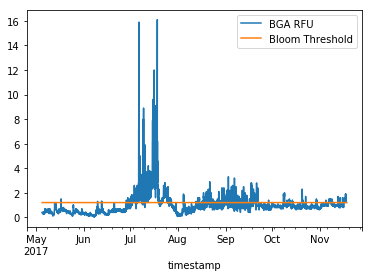

In [52]:
presegmented_plot.plot.line()

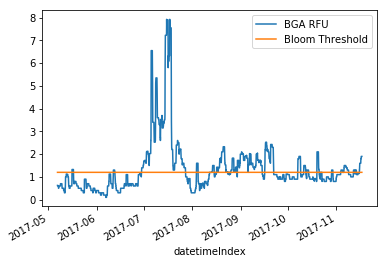

In [53]:
pd.DataFrame({'BGA RFU': train_dfs[train_index][target_column], 
            'Bloom Threshold': np.full(
                train_dfs[train_index].count()[0], RFU_THRESHOLD)}).plot.line()

In [54]:
lrf.add_target_column([train_dfs[train_index], test_dfs[test_index]], 
                      threshold=RFU_THRESHOLD)

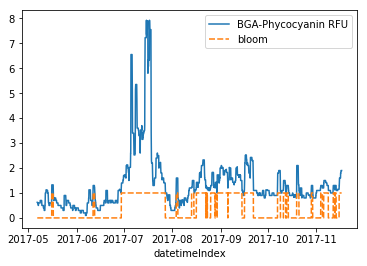

In [55]:
sns.lineplot(data=train_dfs[train_index][[target_column, 'bloom']], hue='bloom')

## Logistic Regression Model
### Null Model

In [56]:
# The null model's performance
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, _, _, _ = lrf.train_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom', null_model=True)
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)
print("columns:", train_dfs[train_index].columns)

Accuracy 0.4197042282857738
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[2015    0]
 [2786    0]]
columns: Index(['BGA-Phycocyanin RFU', 'ODO (mg/L)', 'ODOSat%', 'Sp Cond (uS/cm)',
       'Temp C', 'Turbidity (NTU)', 'datetime', 'pH', 'pH (mV)', 'bloom'],
      dtype='object')


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### All variables model

In [57]:
# All variables model performance
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, _, _, _ = lrf.train_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)
print("columns:", x_columns)

Accuracy 0.6454905228077484
Recall: 1.0
Precision 0.6207664884135472
Confusion Matrix:
 [[ 313 1702]
 [   0 2786]]
columns: ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)', 'ODOSat%', 'ODO (mg/L)']


### Best model to date

In [58]:
max_iter = 25000
loss = "log"
base_columns = ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)']
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, _, _, _ = lrf.train_model(
    model, train_dfs[train_index], test_dfs[test_index], base_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)
print("columns:", base_columns)

Accuracy 0.7865028119141846
Recall: 0.8851399856424982
Precision 0.7776726584673604
Confusion Matrix:
 [[1310  705]
 [ 320 2466]]
columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)']


## Model with relative pH


In [59]:
train = train_dfs[train_index].copy()
test = test_dfs[test_index].copy()
train['pH relative'] = train['pH'] - train['pH'].mean()
test['pH relative'] = test['pH'] - test['pH'].mean()
train.head()

,BGA-Phycocyanin RFU,ODO (mg/L),ODOSat%,Sp Cond (uS/cm),Temp C,Turbidity (NTU),datetime,pH,pH (mV),bloom,pH relative
datetimeIndex,,,,,,,,,,,
2017-05-06 21:36:00,0.625,9.608,97.64,1901.2,16.57,84.926,2017-05-06 21:36:00,8.4,-99.70,0,-0.306179
2017-05-06 22:36:00,0.625,9.608,97.64,1910.4,16.57,85.154,2017-05-06 22:36:00,8.4,-99.60,0,-0.306179
2017-05-06 23:36:00,0.625,9.608,97.64,1914.0,16.57,88.782,2017-05-06 23:36:00,8.4,-99.50,0,-0.306179
2017-05-07 00:36:00,0.625,9.608,97.64,1914.0,16.57,88.812,2017-05-07 00:36:00,8.4,-99.40,0,-0.306179
2017-05-07 01:36:00,0.625,9.608,97.64,1915.0,16.57,88.812,2017-05-07 01:36:00,8.4,-99.36,0,-0.306179


In [60]:
max_iter = 25000
loss = "log"
base_columns = ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)', 'pH relative']
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, _, _, _ = lrf.train_model(
    model, train, test, base_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)
print("columns:", base_columns)

Accuracy 0.8085815455113518
Recall: 0.8636037329504667
Precision 0.8169779286926995
Confusion Matrix:
 [[1476  539]
 [ 380 2406]]
columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)', 'pH relative']


## Add all relative features

In [61]:
relative_names = [col + '_relative' for col in x_columns]
for i in range(0, len(train_dfs)):
    train_dfs[i][relative_names] = train_dfs[i][x_columns] - train_dfs[i][x_columns].mean()
    test_dfs[i][relative_names] = test_dfs[i][x_columns] - test_dfs[i][x_columns].mean()
x_columns = list(set(x_columns + relative_names))
train_dfs[train_index].head()

,BGA-Phycocyanin RFU,ODO (mg/L),ODOSat%,Sp Cond (uS/cm),Temp C,Turbidity (NTU),datetime,pH,pH (mV),bloom,Temp C_relative,Sp Cond (uS/cm)_relative,pH (mV)_relative,pH_relative,Turbidity (NTU)_relative,ODOSat%_relative,ODO (mg/L)_relative
datetimeIndex,,,,,,,,,,,,,,,,,
2017-05-06 21:36:00,0.625,9.608,97.64,1901.2,16.57,84.926,2017-05-06 21:36:00,8.4,-99.70,0,-3.117705,-61.515927,14.065483,-0.306179,-29.136937,-3.840712,0.337533
2017-05-06 22:36:00,0.625,9.608,97.64,1910.4,16.57,85.154,2017-05-06 22:36:00,8.4,-99.60,0,-3.117705,-52.315927,14.165483,-0.306179,-28.908937,-3.840712,0.337533
2017-05-06 23:36:00,0.625,9.608,97.64,1914.0,16.57,88.782,2017-05-06 23:36:00,8.4,-99.50,0,-3.117705,-48.715927,14.265483,-0.306179,-25.280937,-3.840712,0.337533
2017-05-07 00:36:00,0.625,9.608,97.64,1914.0,16.57,88.812,2017-05-07 00:36:00,8.4,-99.40,0,-3.117705,-48.715927,14.365483,-0.306179,-25.250937,-3.840712,0.337533
2017-05-07 01:36:00,0.625,9.608,97.64,1915.0,16.57,88.812,2017-05-07 01:36:00,8.4,-99.36,0,-3.117705,-47.715927,14.405483,-0.306179,-25.250937,-3.840712,0.337533


### Greedy Model

In [62]:
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)
# Sort columns by accuracy
sorted_columns = lrf.sort_columns_by_metric(model, train_dfs[train_index], 
                                            test_dfs[test_index],
                                            x_columns,
                                            'bloom')

Training model with: pH (mV)
Accuracy 0.5802957717142262
Recall: 1.0
Precision 0.5802957717142262
Confusion Matrix:
 [[   0 2015]
 [   0 2786]]

Training model with: ODOSat%
Accuracy 0.7167256821495521
Recall: 0.6920315865039484
Precision 0.7934156378600823
Confusion Matrix:
 [[1513  502]
 [ 858 1928]]

Training model with: Temp C_relative
Accuracy 0.5850864403249323
Recall: 0.3488872936109117
Precision 0.8452173913043478
Confusion Matrix:
 [[1837  178]
 [1814  972]]

Training model with: Sp Cond (uS/cm)_relative


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.4197042282857738
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[2015    0]
 [2786    0]]

Training model with: ODOSat%_relative
Accuracy 0.6954801083107686
Recall: 0.5631730078966259
Precision 0.8649393605292172
Confusion Matrix:
 [[1770  245]
 [1217 1569]]

Training model with: pH (mV)_relative
Accuracy 0.6675692564049156
Recall: 0.5660445082555635
Precision 0.8029531568228105
Confusion Matrix:
 [[1628  387]
 [1209 1577]]

Training model with: pH
Accuracy 0.6854821912101645
Recall: 0.9178033022254127
Precision 0.6662324127149557
Confusion Matrix:
 [[ 734 1281]
 [ 229 2557]]

Training model with: pH_relative
Accuracy 0.714642782753593
Recall: 0.6539842067480258
Precision 0.8177737881508079
Confusion Matrix:
 [[1609  406]
 [ 964 1822]]

Training model with: Temp C
Accuracy 0.6057071443449281
Recall: 0.416367552045944
Precision 0.8128941836019622
Confusion Matrix:
 [[1748  267]
 [1626 1160]]

Training model with: ODO (mg/L)
Accuracy 0.7042282857737971
Recall: 0.682699210337401

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.4197042282857738
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[2015    0]
 [2786    0]]

Training model with: Sp Cond (uS/cm)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.4197042282857738
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[2015    0]
 [2786    0]]

Training model with: Turbidity (NTU)_relative


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.4197042282857738
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[2015    0]
 [2786    0]]

Training model with: ODO (mg/L)_relative
Accuracy 0.6827744219954176
Recall: 0.5398420674802584
Precision 0.86189111747851
Confusion Matrix:
 [[1774  241]
 [1282 1504]]

ODOSat% metric value: 0.7167256821495521
pH_relative metric value: 0.714642782753593
ODO (mg/L) metric value: 0.7042282857737971
ODOSat%_relative metric value: 0.6954801083107686
pH metric value: 0.6854821912101645
ODO (mg/L)_relative metric value: 0.6827744219954176
pH (mV)_relative metric value: 0.6675692564049156
Temp C metric value: 0.6057071443449281
Temp C_relative metric value: 0.5850864403249323
pH (mV) metric value: 0.5802957717142262
Sp Cond (uS/cm)_relative metric value: 0.4197042282857738
Turbidity (NTU) metric value: 0.4197042282857738
Sp Cond (uS/cm) metric value: 0.4197042282857738
Turbidity (NTU)_relative metric value: 0.4197042282857738


In [63]:
#create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)

accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.greedy_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 
                                            'bloom', sorted_columns)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


greedy_columns: []
sorted_columns: ['ODOSat%', 'pH_relative', 'ODO (mg/L)', 'ODOSat%_relative', 'pH', 'ODO (mg/L)_relative', 'pH (mV)_relative', 'Temp C', 'Temp C_relative', 'pH (mV)', 'Sp Cond (uS/cm)_relative', 'Turbidity (NTU)', 'Sp Cond (uS/cm)', 'Turbidity (NTU)_relative']
adjusted sorted_columns: ['ODOSat%', 'pH_relative', 'ODO (mg/L)', 'ODOSat%_relative', 'pH', 'ODO (mg/L)_relative', 'pH (mV)_relative', 'Temp C', 'Temp C_relative', 'pH (mV)', 'Sp Cond (uS/cm)_relative', 'Turbidity (NTU)', 'Sp Cond (uS/cm)', 'Turbidity (NTU)_relative']
Training model with: ['ODOSat%']
Test model accuracy: 0.7167256821495521
Test model recall: 0.6920315865039484
Test model precision: 0.7934156378600823

Updating greedy model

Training model with: ['ODOSat%', 'pH_relative']
Test model accuracy: 0.7481774630285357
Test model recall: 0.7085427135678392
Test model precision: 0.8325601012231126

Updating greedy model

Training model with: ['ODOSat%', 'pH_relative', 'ODO (mg/L)']
Test model accuracy: 0.

Model AUC: 0.8501


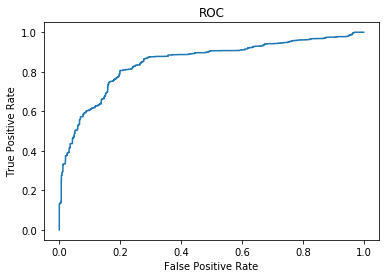

In [64]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test_dfs[test_index][['bloom']].values, predictions)

### Greedy Model With Base Columns

In [65]:
#create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)

accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.greedy_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 
                                            'bloom', sorted_columns, base_columns)


greedy_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)', 'pH relative']
sorted_columns: ['ODOSat%', 'pH_relative', 'ODO (mg/L)', 'ODOSat%_relative', 'pH', 'ODO (mg/L)_relative', 'pH (mV)_relative', 'Temp C', 'Temp C_relative', 'pH (mV)', 'Sp Cond (uS/cm)_relative', 'Turbidity (NTU)', 'Sp Cond (uS/cm)', 'Turbidity (NTU)_relative']
adjusted sorted_columns: ['pH_relative', 'ODOSat%_relative', 'ODO (mg/L)_relative', 'pH (mV)_relative', 'Temp C_relative', 'pH (mV)', 'Sp Cond (uS/cm)_relative', 'Turbidity (NTU)', 'Turbidity (NTU)_relative']
Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)', 'pH relative', 'pH_relative']
Test model accuracy: 0.8085815455113518
Test model recall: 0.8636037329504667
Test model precision: 0.8169779286926995

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)', 'pH relative', 'pH_relative', 'ODOSat%_relative']
Test model accuracy: 0.7840033326390335
Test model r

## Random Forest Model

In [66]:
# All Inputs
model = RandomForestClassifier(n_estimators=100)
accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.train_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)

Accuracy 0.6908977296396585
Recall: 0.7132089016511127
Precision 0.7436377245508982
Confusion Matrix:
 [[1330  685]
 [ 799 1987]]


Model AUC: 0.7644


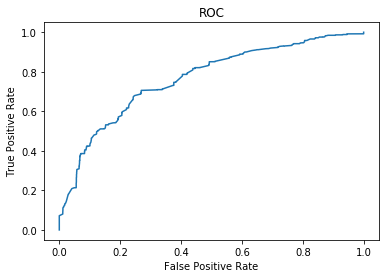

In [67]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test_dfs[test_index][['bloom']].values, predictions)